In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import optimize

In [303]:
path = '/Users/wendy/Desktop/111/GMA/111B_Lab_Voltage_variation_1.csv'
path_bg = '/Users/wendy/Desktop/111/GMA/Wendy&Yilun/wendy have fun/01_28_2022_17_09_05/final_aved_Data3min.csv'

In [304]:
index = pd.read_csv(path) 

In [679]:
background = pd.read_csv(path_bg)
def cutdat(data,lowlim,highlim):
    data_x = data['freq'].values
    data_y = data['vals'].values
    data_y = data_y[(data_x > low_lim) & (data_x < up_lim)]
    data_x = data_x[(data_x > low_lim) & (data_x < up_lim)]
    return(data_x,data_y)
def subtract(data,time,background = background,filenumber = 1):
    freq = data[0].values
    data_sub = data[1].values-background['values'].values/3*(time/60)
    err = (np.sqrt(data[1].values) + (time/180)**2*background['std'])/filenumber
    result = pd.DataFrame([])
    result['freq'] = freq
    result['vals'] = data_sub
    result['std'] = err
    
    return result
def exp(x,ave,sigma,amp,c,b):
    return(amp*np.exp(-(x-ave)**2/(2*sigma**2))+c*x+b)
def mt_fit(data_x,data_y,err_x ,err_y,up_lim,low_lim,N,p0=[1.25,0.05,25,0.1, 0]):

    

    data_y = data_y[(data_x > low_lim) & (data_x < up_lim)]
    
    if type(err_x) is not float:
        err_x = err_x[(data_x > low_lim) & (data_x < up_lim)]
    if type(err_y) is not float:
        err_y = err_y[(data_x > low_lim) & (data_x < up_lim)]
    data_x = data_x[(data_x > low_lim) & (data_x < up_lim)]
    
    func = exp
    ave = []
    sigma = []
    amp = []
    c = []
    b = []
    for i in range(N):
#         data_xe = np.array(data_x)+np.random.normal(0,err_x)
#         data_ye = np.array(data_y)+np.random.normal(0,err_y)

        data_xe = np.random.normal(data_x,err_x)
        data_ye = np.random.normal(data_y,err_y)

        paras, _ = optimize.curve_fit(func, data_xe, data_ye,p0 = p0)
        ave += [paras[0]]
#         print(ave)
        sigma += [paras[1]]
        amp += [paras[2]]
        c += [paras[3]]
        b += [paras[4]]
        
    
#     fig, ax = plt.subplots(figsize = (16,12))

#     ax.scatter(data_x, data_y,s = 0.3)
#     ax.plot(data_x,exp(data_x,*paras), )
#     plt.plot()
    ave_a = np.mean(ave)
    sigma_a = np.mean(sigma)
    amp_a = np.mean(amp)
    c_a = np.mean(c)
    b_a = np.mean(b)
    paras = [ave_a,sigma_a,amp_a,c_a,b_a]
    
    ave_err = np.std(ave)
    sigma_err = np.std(sigma)
    amp_err = np.std(amp)
    c_err = np.std(c)
    b_err = np.std(b)
    obs = data_y
    model = exp(data_x,*paras)
    error = err_y
    def chisquared(obs, model, error):
        return np.average(((obs - model) / error)**2)
    
    chi = chisquared(obs,model,error)
    errs = [ave_err,sigma_err,amp_err,c_err,b_err,chi]
#     errs = [ave_err,sigma_err,amp_err,c_err,b_err]
    
#     plt.scatter(data_x,data_y,s=0.1)
#     plt.plot(np.linspace(min(data_x),max(data_x),100),func(np.linspace(min(data_x),max(data_x),100),ave_a,sigma_a,amp_a,c_a,b_a))
#     plt.show()
    
    return (paras, errs)

In [680]:
index_pb = index[index['Block_material']=='Pb']
index_cu = index[index['Block_material']=='Cu']
index_al = index[index['Block_material']=='Al']

In [681]:
indexs = [index_pb,index_cu,index_al]

In [682]:
indexs

[  Block_material  Thickness_claim  Block_thickness(mm)  Err(mm)  \
 0             Pb            1.058                0.925    0.005   
 1             Pb            0.430                0.855    0.005   
 2             Pb            6.580                6.159    0.005   
 3             Pb            5.365                5.253    0.005   
 4             Pb            0.520                0.930    0.005   
 5             Pb            0.570                1.465    0.005   
 
    Peak_height Cs(Run2) Folder_name Cs  Peak_height Na(Run2) Folder_name Na  
 0                   450       16:24:46                   499       12:44:20  
 1                   450       16:38:10                   485       13:01:36  
 2                   230       16:46:18                   224       12:51:33  
 3                   230       16:53:09                   204       12:55:15  
 4                   400       17:00:39                   460       12:47:44  
 5                   400       17:04:09         

In [683]:
files = glob("**/*/",recursive = True)
glob('**/**.dat',recursive = True)
cs = {}
for j,names in enumerate(['pb','cu','al']):
    for file in files:
        for i,slab_names in enumerate(indexs[j]['Folder_name Cs']):
            
            pb_names = slab_names.replace(':','_')
#             print(i)
            if pb_names in file:
                l = np.array(indexs[j]['Block_thickness(mm)'])
                
                file = glob('{}**.dat'.format(file))
#                 print(file)
                cs[names,l[i]] = file[-1]
                

In [684]:
cs_keys = np.array(list(cs))
cs_files = list(cs.values())

In [685]:
peaks_cs = {}
errs_cs = {}
for i,file in enumerate(cs_files):
    #plot data and find the optimal range
    data = pd.read_csv(file,skiprows = 2,sep="\s+", header = None,usecols = [0,1])
    up_lim = 1.2
    low_lim = 0.8
    dat_sub_cs300 = subtract(data,300,filenumber = 1)
    #Finally do the montecarlo fit with estimate of error
    dat_sub = dat_sub_cs300
    datx, daty = cutdat(dat_sub,low_lim,up_lim)
    par = [0.9909483763329884,-0.02994158305071405,303.6078281337044,-10,50]
    Cs_paras, Cs_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0.005, dat_sub['std'].values, \
           up_lim,low_lim,1000,p0 = par)
    print(list(cs)[i],Cs_paras[2],file)
    peaks_cs[cs_keys[i][0],cs_keys[i][1]] = Cs_paras[2]
    errs_cs[cs_keys[i][0],cs_keys[i][1]] = Cs_errs[2]

('pb', 6.159) 209.8068733957353 Cs137/Pb/01_28_2022_16_46_18/01_28_2022_16_49_19.dat
('pb', 0.93) 373.56258628744826 Cs137/Pb/01_28_2022_17_00_39/01_28_2022_17_03_41.dat
('pb', 1.465) 375.53937959627297 Cs137/Pb/01_28_2022_17_04_09/01_28_2022_17_07_11.dat
('pb', 0.855) 399.69841603673467 Cs137/Pb/01_28_2022_16_38_10/01_28_2022_16_44_12.dat
('pb', 0.925) 393.1581496296578 Cs137/Pb/01_28_2022_16_24_46/01_28_2022_16_30_48.dat
('pb', 5.253) 192.67664879888974 Cs137/Pb/01_28_2022_16_53_09/01_28_2022_16_56_11.dat
('cu', 15.26) 155.39966728600567 Cs137/01_31_2022_15_02_11/01_31_2022_15_05_12.dat
('cu', 6.396) 267.095248445679 Cs137/01_31_2022_14_57_51/01_31_2022_15_00_56.dat
('cu', 0.78) 385.7298467776312 Cs137/01_31_2022_14_49_02/01_31_2022_14_52_04.dat
('cu', 2.17) 345.2151989100456 Cs137/01_31_2022_14_53_43/01_31_2022_14_56_46.dat
('al', 9.815) 335.6483520765603 Cs137/Al/01_31_2022_14_10_25/01_31_2022_14_13_32.dat
('al', 1.049) 397.45090814073086 Cs137/Al/01_31_2022_14_02_29/01_31_2022_14_

In [404]:
index

,Block_material,Thickness_claim,Block_thickness(mm),Err(mm),Peak_height Cs(Run2),Folder_name Cs,Peak_height Na(Run2),Folder_name Na
0,Pb,1.058,0.925,0.005,450,16:24:46,499,12:44:20
1,Pb,0.430,0.855,0.005,450,16:38:10,485,13:01:36
2,Pb,6.580,6.159,0.005,230,16:46:18,224,12:51:33
3,Pb,5.365,5.253,0.005,230,16:53:09,204,12:55:15
4,Pb,0.520,0.930,0.005,400,17:00:39,460,12:47:44
5,Pb,0.570,1.465,0.005,400,17:04:09,458,13:07:03
6,Cu,15.250,15.260,0.005,170,15:02:11,213,13:13:06
7,Cu,6.330,6.396,0.005,289,14:57:51,377,13:17:06
8,Cu,2.140,2.170,0.005,361,14:53:43,492,13:22:36
9,Cu,0.751,0.780,0.005,443,14:49:02,536,13:26:11


In [418]:
na = {}
files = glob("**/*/",recursive = True)
for j,names in enumerate(['pb','cu','al']):
    for file in files:
        for i,slab_names in enumerate(indexs[j]['Folder_name Na']):
            
            pb_names = slab_names.replace(':','_')
#             print(i)
            if pb_names in file:
                l = np.array(indexs[j]['Block_thickness(mm)'])
                
                file = glob('{}**.dat'.format(file))
                print(file)
                na[names,l[i]] = file[-1]

['Na22/pb/01_31_2022_12_55_15/01_31_2022_12_58_18.dat']
['Na22/pb/01_31_2022_13_01_36/01_31_2022_13_04_42.dat']
['Na22/pb/01_31_2022_12_47_44/01_31_2022_12_50_48.dat']
['Na22/pb/01_31_2022_13_07_03/01_31_2022_13_10_11.dat']
['Na22/pb/01_31_2022_12_44_20/01_31_2022_12_47_23.dat']
['Na22/pb/01_31_2022_12_51_33/01_31_2022_12_54_38.dat']
['Na22/cu/01_31_2022_13_26_11/01_31_2022_13_29_19.dat']
['Na22/cu/01_31_2022_13_29_42/01_31_2022_13_32_45.dat']
['Na22/cu/01_31_2022_13_22_36/01_31_2022_13_25_43.dat']
['Na22/cu/01_31_2022_13_17_06/01_31_2022_13_20_10.dat']
['Na22/cu/01_31_2022_13_13_06/01_31_2022_13_16_11.dat']
['Na22/al/01_31_2022_13_45_01/01_31_2022_13_48_07.dat']
['Na22/al/01_31_2022_13_37_19/01_31_2022_13_40_23.dat']
['Na22/al/01_31_2022_13_33_41/01_31_2022_13_36_48.dat']
['Na22/al/01_31_2022_13_41_02/01_31_2022_13_44_11.dat']
['Na22/al/01_31_2022_13_52_47/01_31_2022_13_56_01.dat']
['Na22/al/01_31_2022_13_48_47/01_31_2022_13_51_55.dat']


In [415]:
na

{('pb', 6.159): 'Cs137/Pb/01_28_2022_16_46_18/01_28_2022_16_49_19.dat',
 ('pb', 0.93): 'Cs137/Pb/01_28_2022_17_00_39/01_28_2022_17_03_41.dat',
 ('pb', 1.465): 'Cs137/Pb/01_28_2022_17_04_09/01_28_2022_17_07_11.dat',
 ('pb', 0.855): 'Cs137/Pb/01_28_2022_16_38_10/01_28_2022_16_44_12.dat',
 ('pb', 0.925): 'Cs137/Pb/01_28_2022_16_24_46/01_28_2022_16_30_48.dat',
 ('pb', 5.253): 'Cs137/Pb/01_28_2022_16_53_09/01_28_2022_16_56_11.dat',
 ('cu', 15.26): 'Cs137/01_31_2022_15_02_11/01_31_2022_15_05_12.dat',
 ('cu', 6.396): 'Cs137/01_31_2022_14_57_51/01_31_2022_15_00_56.dat',
 ('cu', 0.78): 'Cs137/01_31_2022_14_49_02/01_31_2022_14_52_04.dat',
 ('cu', 2.17): 'Cs137/01_31_2022_14_53_43/01_31_2022_14_56_46.dat',
 ('al', 9.815): 'Cs137/Al/01_31_2022_14_10_25/01_31_2022_14_13_32.dat',
 ('al', 1.049): 'Cs137/Al/01_31_2022_14_02_29/01_31_2022_14_05_46.dat',
 ('al', 25.465): 'Cs137/Al/01_31_2022_14_18_34/01_31_2022_14_21_35.dat',
 ('al', 6.481): 'Cs137/Al/01_31_2022_14_06_49/01_31_2022_14_09_55.dat',
 ('al'

In [419]:
na_keys = np.array(list(na))
na_files = list(na.values())

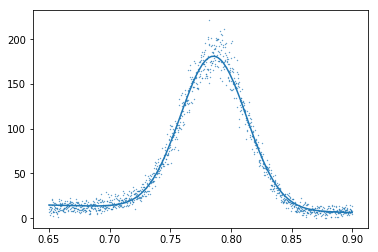

('pb', 5.253) 170.85708361038678 Na22/pb/01_31_2022_12_55_15/01_31_2022_12_58_18.dat


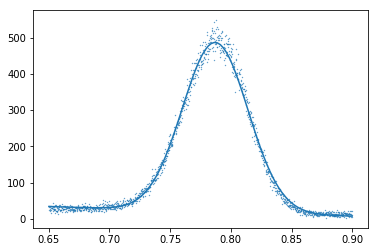

('pb', 0.855) 467.5228348025529 Na22/pb/01_31_2022_13_01_36/01_31_2022_13_04_42.dat


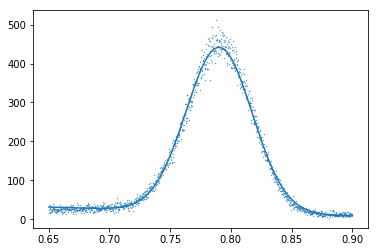

('pb', 0.93) 423.52276409575677 Na22/pb/01_31_2022_12_47_44/01_31_2022_12_50_48.dat


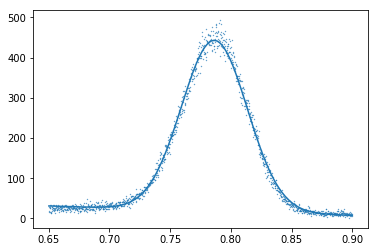

('pb', 1.465) 424.8176657061843 Na22/pb/01_31_2022_13_07_03/01_31_2022_13_10_11.dat


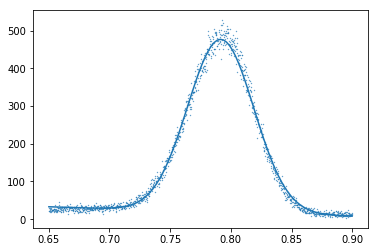

('pb', 0.925) 457.87268184576277 Na22/pb/01_31_2022_12_44_20/01_31_2022_12_47_23.dat


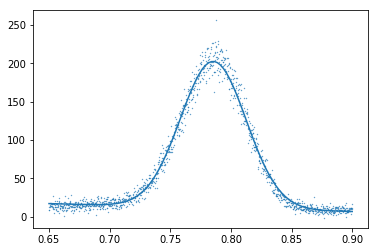

('pb', 6.159) 190.83013065116978 Na22/pb/01_31_2022_12_51_33/01_31_2022_12_54_38.dat


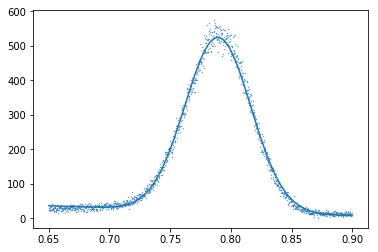

('cu', 0.78) 503.74843748033925 Na22/cu/01_31_2022_13_29_42/01_31_2022_13_32_45.dat


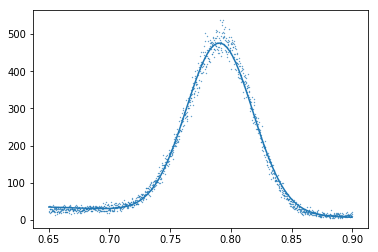

('cu', 2.17) 456.9589739960325 Na22/cu/01_31_2022_13_22_36/01_31_2022_13_25_43.dat


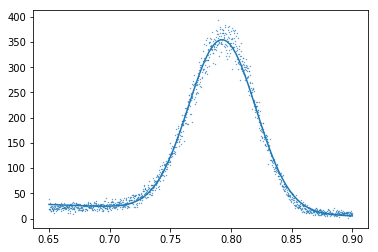

('cu', 6.396) 339.8128363794178 Na22/cu/01_31_2022_13_17_06/01_31_2022_13_20_10.dat


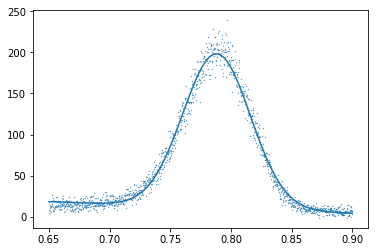

('cu', 15.26) 188.01117650710455 Na22/cu/01_31_2022_13_13_06/01_31_2022_13_16_11.dat


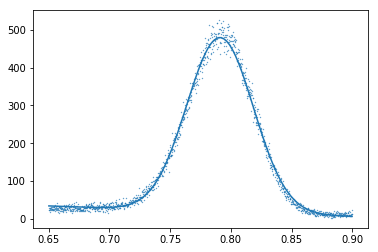

('al', 6.481) 461.00928574560004 Na22/al/01_31_2022_13_45_01/01_31_2022_13_48_07.dat


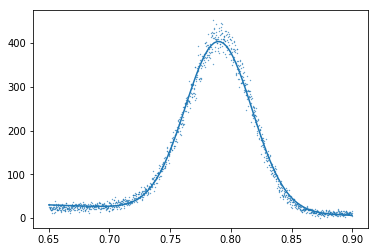

('al', 14.995) 386.9204756579914 Na22/al/01_31_2022_13_37_19/01_31_2022_13_40_23.dat


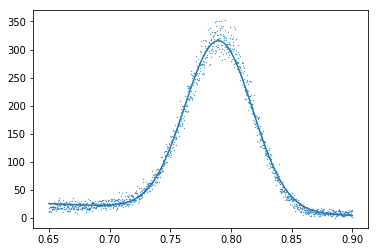

('al', 25.465) 301.8481928422261 Na22/al/01_31_2022_13_33_41/01_31_2022_13_36_48.dat


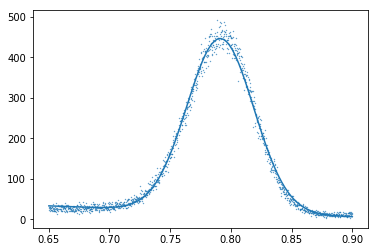

('al', 9.815) 429.028102833219 Na22/al/01_31_2022_13_41_02/01_31_2022_13_44_11.dat


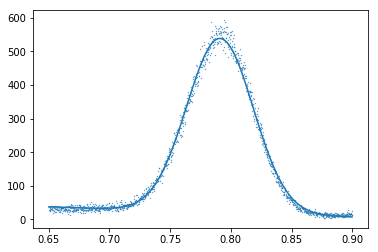

('al', 0.828) 518.0030072191354 Na22/al/01_31_2022_13_52_47/01_31_2022_13_56_01.dat


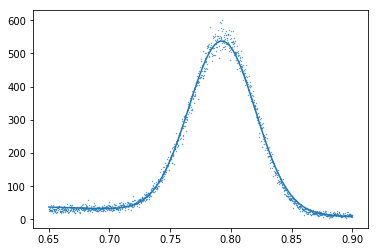

('al', 1.049) 517.2237210680364 Na22/al/01_31_2022_13_48_47/01_31_2022_13_51_55.dat


In [420]:
peaks_na1 = {}
errs_na1 = {}
for i,file in enumerate(na_files):
    #plot data and find the optimal range
    data = pd.read_csv(file,skiprows = 2,sep="\s+", header = None,usecols = [0,1])
    up_lim = 0.9
    low_lim = 0.65
    dat_sub_cs300 = subtract(data,300,filenumber = 1)
    #Finally do the montecarlo fit with estimate of error
    dat_sub = dat_sub_cs300
    datx, daty = cutdat(dat_sub,low_lim,up_lim)
    p0 = [0.79,0.01,500,0,0]
    par = p0
    
    Cs_paras, Cs_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0.005, dat_sub['std'].values, \
           up_lim,low_lim,1000,p0 = par)
    print(list(na)[i],Cs_paras[2],file)
    peaks_na1[na_keys[i][0],na_keys[i][1]] = Cs_paras[2]
    errs_na1[na_keys[i][0],na_keys[i][1]] = Cs_errs[2]

In [371]:
index

,Block_material,Thickness_claim,Block_thickness(mm),Err(mm),Peak_height Cs(Run2),Folder_name Cs,Peak_height Na(Run2),Folder_name Na
0,Pb,1.058,0.925,0.005,450,16:24:46,499,12:44:20
1,Pb,0.430,0.855,0.005,450,16:38:10,485,13:01:36
2,Pb,6.580,6.159,0.005,230,16:46:18,224,12:51:33
3,Pb,5.365,5.253,0.005,230,16:53:09,204,12:55:15
4,Pb,0.520,0.930,0.005,400,17:00:39,460,12:47:44
5,Pb,0.570,1.465,0.005,400,17:04:09,458,13:07:03
6,Cu,15.250,15.260,0.005,170,15:02:11,213,13:13:06
7,Cu,6.330,6.396,0.005,289,14:57:51,377,13:17:06
8,Cu,2.140,2.170,0.005,361,14:53:43,492,13:22:36
9,Cu,0.751,0.780,0.005,443,14:49:02,536,13:26:11


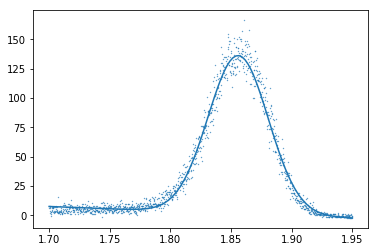

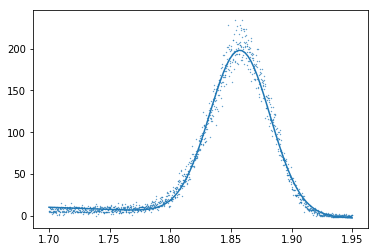

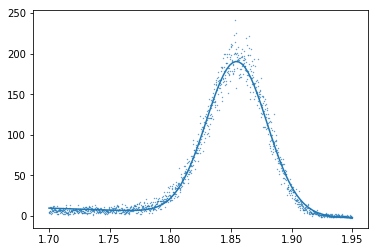

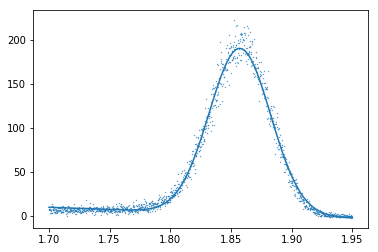

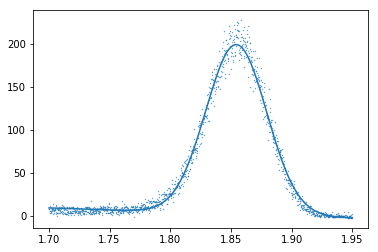

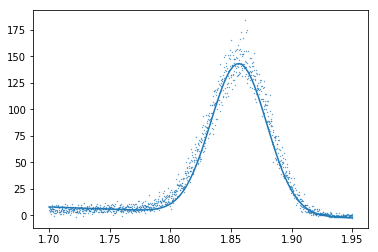

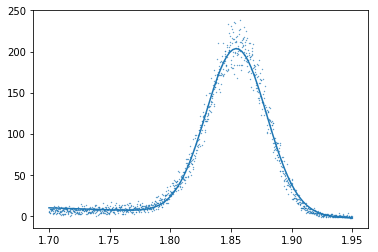

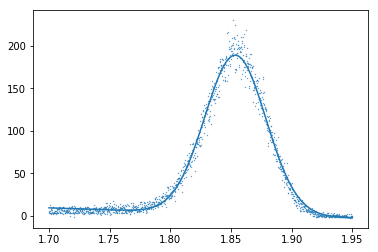

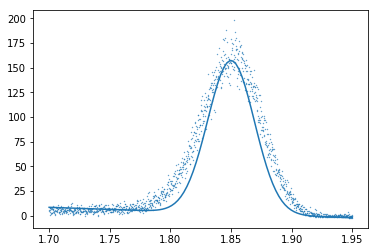

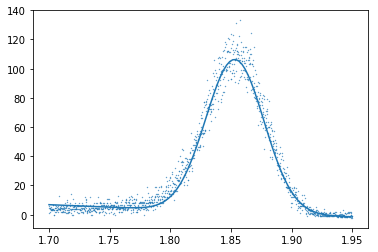

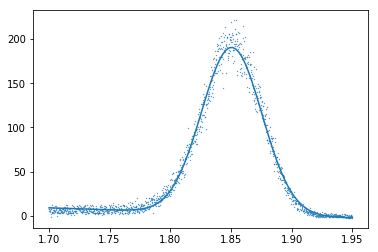

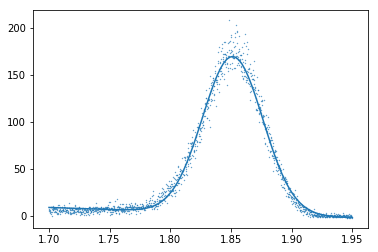

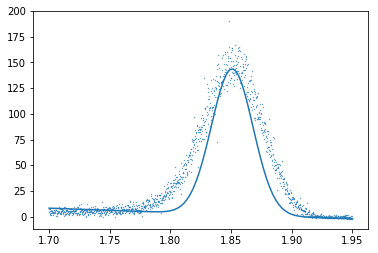

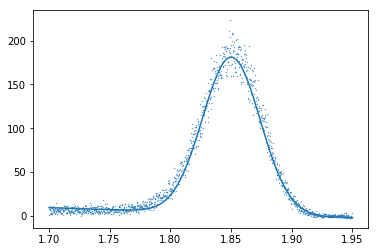

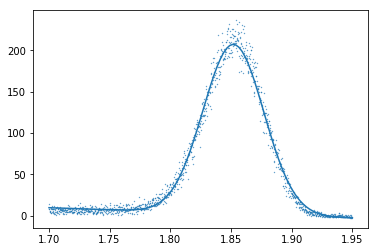

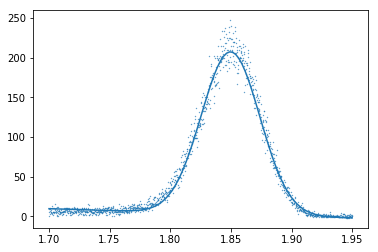

In [421]:
peaks_na2 = {}
errs_na2 = {}
for i,file in enumerate(na_files):
    #plot data and find the optimal range
    data = pd.read_csv(file,skiprows = 2,sep="\s+", header = None,usecols = [0,1])
    up_lim = 1.95
    low_lim = 1.7
    p0 = [1.82,0.01,400,0,0]
    dat_sub_cs300 = subtract(data,300,filenumber = 1)
    #Finally do the montecarlo fit with estimate of error
    dat_sub = dat_sub_cs300
    datx, daty = cutdat(dat_sub,low_lim,up_lim)
    par = p0
    Cs_paras, Cs_errs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0.005, dat_sub['std'].values, \
           up_lim,low_lim,1000,p0 = par)
    peaks_na2[na_keys[i][0],na_keys[i][1]] = Cs_paras[2]
    errs_na2[na_keys[i][0],na_keys[i][1]] = Cs_errs[2]

In [364]:
na_files

[]

In [358]:
entires = ('pb', '6.159')

In [359]:
'pb' in entires

True

In [435]:
def extract(peaks_cs,errs_cs):
    pb = []
    cu = []
    al = []
    for entries in list(peaks_cs):
#         print(entries)
#         print(entries)
        if 'pb' in entries:
            pb +=[[entries[1],peaks_cs[entries],errs_cs[entries]]]
        elif 'cu' in entries:
            cu +=[[entries[1],peaks_cs[entries],errs_cs[entries]]]
        elif 'al' in entries:
            al +=[[entries[1],peaks_cs[entries],errs_cs[entries]]]
            
    return (pb,cu,al)

In [436]:
extract(peaks_cs,errs_cs)

([['6.159', 209.8321191033029, 1.250622832004859],
  ['0.93', 373.5213314536485, 1.8649215543394002],
  ['1.465', 375.5319761604429, 1.885730587614203],
  ['0.855', 399.6639593315693, 2.036839558324515],
  ['0.925', 393.16033775791993, 2.038942368738076],
  ['5.253', 192.67398430044273, 1.2236187822052735]],
 [['15.26', 155.3936765976675, 1.0195654572606272],
  ['6.396', 267.0221138723654, 1.493241556745842],
  ['0.78', 385.79095091420623, 1.9437156627900773],
  ['2.17', 345.24920499976076, 1.7094839526987613]],
 [['9.815', 335.55577207459964, 1.8566943834423304],
  ['1.049', 397.54186796927803, 2.1433828896114426],
  ['25.465', 242.4627403730148, 1.431557095249133],
  ['6.481', 360.0813022353021, 1.920618323820204],
  ['0.828', 397.3385763626081, 1.9998518184977767],
  ['14.995', 304.93087989437765, 1.5912751997783399]])

In [437]:
#evaluate the empty spectrum:
path_emp_na = '/Users/wendy/Desktop/111/GMA/Wendy&Yilun/Absorption(9)/Na22/pb/01_31_2022_12_32_17/01_31_2022_12_35_19.dat'
path_emp_cs = '/Users/wendy/Desktop/111/GMA/Wendy&Yilun/Inverse_Square(7)/01_28_2022_13_28_36/01_28_2022_13_31_39.dat'

In [438]:
emp_na = pd.read_csv(path_emp_na,skiprows = 2,sep="\s+", header = None,usecols = [0,1])
emp_cs = pd.read_csv(path_emp_cs,skiprows = 2,sep="\s+", header = None,usecols = [0,1])

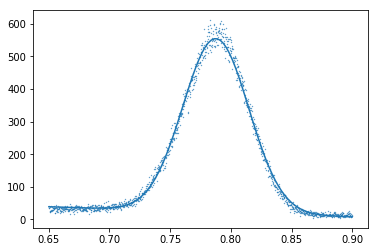

In [439]:
up_lim = 0.9
low_lim = 0.65
p0 = [0.79,0.01,500,0,0]

data = emp_na
dat_sub = subtract(data,300,filenumber = 1)
#Finally do the montecarlo fit with estimate of error
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par = p0
paras_emp_na1, errs_emp_na1 = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0.005, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

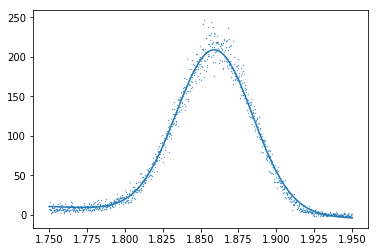

In [501]:
up_lim = 1.95
low_lim = 1.75
p0 = [1.85,0.01,200,0,0]

data = emp_na
dat_sub = subtract(data,300,filenumber = 1)
#Finally do the montecarlo fit with estimate of error
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par = p0
paras_emp_na2, errs_emp_na2 = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0.005, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)
# peaks_empna[na_keys[i][0],na_keys[i][1]] = paras[2]
# peaks_empna[na_keys[i][0],na_keys[i][1]] = errs[2]

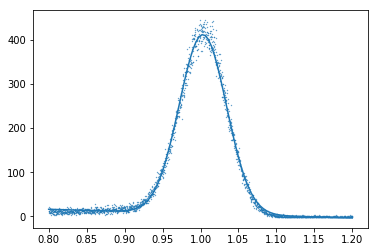

In [441]:
up_lim = 1.2
low_lim = 0.8
p0 = [0.9909483763329884,-0.02994158305071405,400.6078281337044,-10,50]

data = emp_cs
dat_sub = subtract(data,300,filenumber = 1)
#Finally do the montecarlo fit with estimate of error
datx, daty = cutdat(dat_sub,low_lim,up_lim)
par = p0
paras_emp_cs, errs_emp_cs = mt_fit(dat_sub['freq'].values,dat_sub['vals'].values,0.005, dat_sub['std'].values, \
       up_lim,low_lim,1000,p0 = par)

In [504]:
errs_emp_cs

[0.0002464902130759908,
 0.00020134801991893636,
 2.0756945444925736,
 0.9484270778450901,
 1.018131894010998]

In [442]:
len_err_pb = np.array([0.4,0.4,0.8,0.425,0.1,0.1])/2
len_err_cu = np.array([0.005])

In [443]:
len(cu)

5

In [467]:
def intensity1(t,mu,I0):
    t = np.array(t)/10
#     I  = I0[i]
    return(I0*np.exp(-mu*t))
def fit_intensity(i0,i0_err,elem_dat,err_len, N,p0):
    mu = []
    
    elem_dat = np.array(elem_dat,dtype = float)
    data_x = np.array(elem_dat[:,0])/10
    err_x = np.array(err_len)/10
    data_y = elem_dat[:,1]
    err_y = elem_dat[:,2]
#     print(data_x,err_x)
    I0 = np.empty(N)
    I0.fill(i0)
    I0_err = np.empty(N)
    I0_err.fill(i0_err)
    I0 = np.random.normal(I0,I0_err)
    


    for i in range(N):
        def intensity(t,mu):
            t = np.array(t)
            I  = I0[i]
            return(I*np.exp(-mu*t))
        
        data_xe = np.random.normal(data_x,err_x)
#         print(data_y,err_y)
        data_ye = np.random.normal(data_y,err_y)

        paras, _ =optimize.curve_fit(intensity,data_xe,data_ye,p0=p0)
        mu +=[paras[0]]

    mu_ave = np.mean(mu)
    mu_err = np.std(mu)
    
    return (mu_ave, mu_err)





In [445]:
extract(peaks_cs,errs_cs)

([['6.159', 209.8321191033029, 1.250622832004859],
  ['0.93', 373.5213314536485, 1.8649215543394002],
  ['1.465', 375.5319761604429, 1.885730587614203],
  ['0.855', 399.6639593315693, 2.036839558324515],
  ['0.925', 393.16033775791993, 2.038942368738076],
  ['5.253', 192.67398430044273, 1.2236187822052735]],
 [['15.26', 155.3936765976675, 1.0195654572606272],
  ['6.396', 267.0221138723654, 1.493241556745842],
  ['0.78', 385.79095091420623, 1.9437156627900773],
  ['2.17', 345.24920499976076, 1.7094839526987613]],
 [['9.815', 335.55577207459964, 1.8566943834423304],
  ['1.049', 397.54186796927803, 2.1433828896114426],
  ['25.465', 242.4627403730148, 1.431557095249133],
  ['6.481', 360.0813022353021, 1.920618323820204],
  ['0.828', 397.3385763626081, 1.9998518184977767],
  ['14.995', 304.93087989437765, 1.5912751997783399]])

In [433]:
dat

array([[  5.253     , 199.66993265,   1.5184058 ],
       [  0.93      , 201.29741107,   1.53512211],
       [  6.159     , 187.02832408,   1.39140448],
       [  0.855     , 155.08067356,   1.21265526],
       [  0.925     , 104.74663689,   0.93194299]])

In [449]:
paras

([['6.159', 209.8321191033029, 1.250622832004859],
  ['0.93', 373.5213314536485, 1.8649215543394002],
  ['1.465', 375.5319761604429, 1.885730587614203],
  ['0.855', 399.6639593315693, 2.036839558324515],
  ['0.925', 393.16033775791993, 2.038942368738076],
  ['5.253', 192.67398430044273, 1.2236187822052735]],
 [['15.26', 155.3936765976675, 1.0195654572606272],
  ['6.396', 267.0221138723654, 1.493241556745842],
  ['0.78', 385.79095091420623, 1.9437156627900773],
  ['2.17', 345.24920499976076, 1.7094839526987613]],
 [['9.815', 335.55577207459964, 1.8566943834423304],
  ['1.049', 397.54186796927803, 2.1433828896114426],
  ['25.465', 242.4627403730148, 1.431557095249133],
  ['6.481', 360.0813022353021, 1.920618323820204],
  ['0.828', 397.3385763626081, 1.9998518184977767],
  ['14.995', 304.93087989437765, 1.5912751997783399]])

In [532]:
density

{'pb': 11.29}

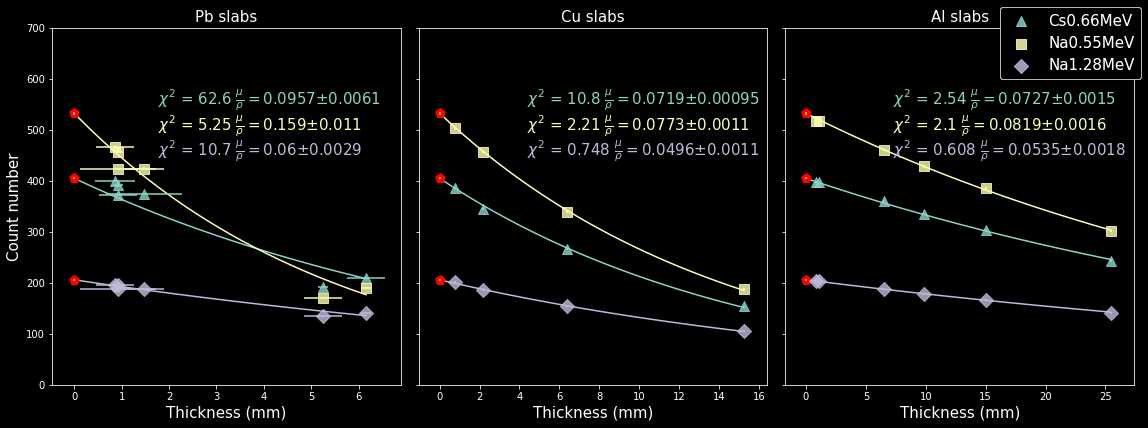

In [677]:
plt.style.use('dark_background')
fig, axs =  plt.subplots(1,3,figsize = (16,6),sharey = True)

slabs = ['Pb','Cu','Al']
peaks = ['Cs0.66MeV','Na0.55MeV', 'Na1.28MeV']
density = {'Pb':11.29,'Al':2.7,'Cu':8.96}
markers = {'Cs0':'^','Na0':'s','Na1':'D'}

cs = extract(peaks_cs,errs_cs)
na1 = extract(peaks_na1,errs_na1)
na2 = extract(peaks_na2,errs_na2)
a = [cs,na1,na2] #paras are for a single source



len_err_pb = np.array([0.4,0.4,0.8,0.425,0.1,0.1])
len_err_cu = np.array([0.05,0.05,0.05,0.05,])
len_err_al = np.array([0.05,0.05,0.05,0.05,0.05,0.05])

len_err = [len_err_pb,len_err_cu,len_err_al]



iall = [paras_emp_cs[2],paras_emp_na1[2],paras_emp_na2[2]]
ierrall = [errs_emp_cs[2],errs_emp_na1[2],errs_emp_na2[2]]
color = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']

# mu = []
# mue = []
p0 = [[1.1031683792936817,1.8415294905494333,0.9289869930234624],
     [0.6447545982179306,0.6917529071617879,0.214039502930117],
     [0.19710005009142648,0.22128947000862673,0.1254226975246]]

    
for j in range(len(a)): #plot number, the slabs
# if True:
#     j=2
    mu1 = []
    mue1 = []
    for i,paras in enumerate((a)): #curve number, the sources
    #         print(i)
        dat = np.array(paras[j],dtype = float)
#         print(dat)
        p00 = p0[j][i]
        emp = iall[i]
        emp_err = ierrall[i]
        len_err_ = len_err[j]
    #         print(dat)
    #         print(len(len_err_),len(dat))


        muu, mu_err = fit_intensity(emp,emp_err,dat,len_err_,1000,p00)
#         print(muu)
    #     print(dat,color[i],muu)
            
        axs[j].scatter(0,emp,s=100,marker = 'p',c = 'r')
        axs[j].scatter(dat[:,0],dat[:,1],color = color[i],label = peaks[i],s = 100,marker = markers[peaks[i][:3]],alpha = 0.8)

        xx = np.linspace(0,max(dat[:,0]/10),100)
        
        axs[j].set_title('{} slabs'.format(slabs[j]),fontsize = 15)
        
        axs[j].plot(xx*10,intensity(xx,muu,emp),c = color[i],zorder = -1)
        axs[j].errorbar(0,emp,emp_err,c = color[-1])
        axs[j].errorbar(dat[:,0],dat[:,1],dat[:,2],len_err_,ls = 'none',c = color[i])
#         
        mmu = muu/density[slabs[j]]
        mmu_err = mu_err/density[slabs[j]]
        def chisquared(obs, model, error):
            return sum(((obs - model) / error)**2)
        def invexp(x):
            return(-np.log(x/emp)/muu)
        chi1 = chisquared(dat[:,1],intensity(dat[:,0]/10,muu,emp),dat[:,2])
        chi2 = chisquared(dat[:,0],invexp(dat[:,1])*10,len_err_)
#         print(chi2)
        
        chi = min(chi1,chi2)/(len(len_err_)-1)
        axs[j].text(max(dat[:,0])/3.5,(550-i*50),
                    (r'$\chi^2$ = {:.3g} '.format(chi)+r"$\frac{\mu}{\rho} =$"+'{:.3g}'.format(mmu)+r'$\pm$'+'{:.2g}'.format(mmu_err)), 
                    color = color[i],fontsize = 15)
#       
        axs[j].set_xlabel('Thickness (mm)',fontsize = 15)
        axs[j].set_ylim(0,700)
        mu1 +=[muu]
        mue1 +=[mu_err]
    axs[0].set_ylabel('Count number',fontsize = 15)
    handles, labels = axs[j].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right',fontsize = 15)
    plt.tight_layout()
#     plt.grid()
    mu += [mu1]
    mue +=[mue1]
    
#     plt.plot(np.linspace(min(pb[:,0]),max(pb[:,0]),100)
#              ,intensity1(np.linspace(min(pb[:,0]),max(pb[:,0]),100),mu,paras_emp_cs[2]))
    
    
        
        



In [646]:
def chisquared(obs, model, error):
    return sum(((obs - model) / error)**2)
def invexp(x):
    return(-np.log(x/emp)/muu)
chi = chisquared(dat[:,1],intensity(dat[:,0]/10,muu,emp),)

In [669]:
invexp(dat[:,1])

array([0.63761567, 1.45359579, 2.60032315, 0.99579582, 0.05226292,
       0.04816384])

In [647]:
dat[:,1]-intensity(dat[:,0]/10,muu,emp)

array([ 0.36614125,  1.27036641, -0.85667422, -0.24902016,  0.90902261,
        1.67995516])

In [667]:
arr = intensity(dat[:,0],muu,emp)
invexp(arr)

array([ 6.481, 14.995, 25.465,  9.815,  0.828,  1.049])

In [668]:
dat[:,0]

array([ 6.481, 14.995, 25.465,  9.815,  0.828,  1.049])

In [161]:
mu, _ = fit_intensity(paras_emp_cs[2],errs_emp_cs[2],pb,len_err_pb,10)

In [ ]:
mu, _ = fit_intensity(paras_emp_cs[2],errs_emp_cs[2],pb,len_err_pb,10)

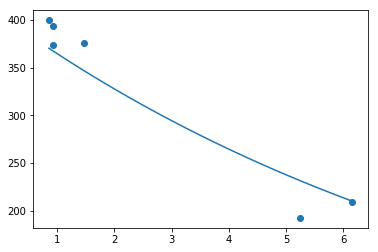

In [164]:
plt.scatter(pb[:,0],pb[:,1])
plt.plot(np.linspace(min(pb[:,0]),max(pb[:,0]),100),intensity1(np.linspace(min(pb[:,0]),max(pb[:,0]),100),mu,paras_emp_cs[2]))

In [152]:
paras_emp_cs[2]

405.75025335934305

In [117]:
pb,cu,al = extract(peaks_cs,errs_cs)

In [121]:
pb = np.array(pb,dtype = float)

In [122]:
pb[:,0]

array([6.159, 0.93 , 1.465, 0.855, 0.925, 5.253])

In [104]:
i0 = paras_emp_cs[2]
i0_err = errs_emp_cs[2]
data_x = 

In [105]:
cs_dat = extract(peaks_cs,errs_cs)

([['6.159', 209.7862432059693, 1.2695301551697933],
  ['0.93', 373.5290643962454, 1.8586286866666732],
  ['1.465', 375.5402965492962, 1.9941505262778327],
  ['0.855', 399.65289814992303, 2.0264746716156714],
  ['0.925', 393.1601374655959, 1.9735253406932494],
  ['5.253', 192.6501808077795, 1.222014323345851]],
 [['0.925', 155.37064218420338, 1.0217808898055085],
  ['0.855', 267.0534519489146, 1.536456244287155],
  ['0.93', 376.9506162880757, 1.890361302326728],
  ['6.159', 345.23666621239016, 1.8541262581254396],
  ['5.253', 385.8081898946358, 2.023596879750636]],
 [['0.855', 304.84602046098894, 1.6466586683400788],
  ['6.159', 335.5347779783986, 1.8503898283867597],
  ['0.93', 397.5793747148201, 2.1008358554187607],
  ['0.925', 242.49009697977098, 1.3492038408449316],
  ['5.253', 359.94798871526694, 1.9411600815205736],
  ['1.465', 397.42999717777235, 1.9976582337822717]])

In [112]:
extract(peaks_cs,errs_cs)

([['6.159', 209.7862432059693, 1.2695301551697933],
  ['0.93', 373.5290643962454, 1.8586286866666732],
  ['1.465', 375.5402965492962, 1.9941505262778327],
  ['0.855', 399.65289814992303, 2.0264746716156714],
  ['0.925', 393.1601374655959, 1.9735253406932494],
  ['5.253', 192.6501808077795, 1.222014323345851]],
 [['0.925', 155.37064218420338, 1.0217808898055085],
  ['0.855', 267.0534519489146, 1.536456244287155],
  ['0.93', 376.9506162880757, 1.890361302326728],
  ['6.159', 345.23666621239016, 1.8541262581254396],
  ['5.253', 385.8081898946358, 2.023596879750636]],
 [['0.855', 304.84602046098894, 1.6466586683400788],
  ['6.159', 335.5347779783986, 1.8503898283867597],
  ['0.93', 397.5793747148201, 2.1008358554187607],
  ['0.925', 242.49009697977098, 1.3492038408449316],
  ['5.253', 359.94798871526694, 1.9411600815205736],
  ['1.465', 397.42999717777235, 1.9976582337822717]])

In [94]:
a

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10.])